<a href="https://colab.research.google.com/github/pedromperezc/EY_CHALLENGE/blob/master/notebooks/VALIDATION_NOTEBOOK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# INSTALATIONS

In [ ]:
!pip install xarray[io] -q

In [ ]:
!pip install contextily -q

# IMPORTING LIBRARIES

In [ ]:
# general
import pandas as pd
import os
import numpy as np
import pickle
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

#geolocation
from geopy.exc import GeocoderTimedOut 
from geopy.geocoders import Nominatim
import xarray as xr
import contextily as cx
from itertools import cycle

# UTIL FUNTIONS

In [ ]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("lat", "lon")).transpose()
    # Reorder variables to be in same order as model


    # predictor_image = predictor_image.sel(variable=model.feature_names_in_)
    predictor_image = predictor_image.sel(variable= model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    # probabilities[~null_pixels] = model.predict_proba(predictor_image[~null_pixels])
    probabilities[~null_pixels] = model.predict_proba(pd.DataFrame(predictor_image[~null_pixels].values, columns=model.feature_names_in_))
    
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

In [ ]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 2, figsize = (20, 10), sharex=True, sharey=True)
    extent = [resultant_image.lon.min(),resultant_image.lon.max(),resultant_image.lat.min(),resultant_image.lat.max()]
    cmap = 'PiYG'

  
    # Plot heatmap from model
    heatmap = resultant_image.plot.imshow(
        x='lon', y='lat', ax=ax[0], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[0].set_aspect('equal')
    ax[0].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>0.5).plot.imshow(
            x='lon', y='lat', ax=ax[1], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[1].set_aspect('equal')
    ax[1].set_title('Model Classification Regions')

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)

In [ ]:
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

In [ ]:
def test_regions(model, weather_data, print):
# Read in test regions
  test_file = pd.read_csv('/content/drive/MyDrive/EY/Level_1_challenge_1_submission_template.csv')
  test_1_regions = []
  with open('/content/drive/MyDrive/EY/challenge_1_test_regions.txt', 'r') as file: 
      for i, line in enumerate(file):
          if i > 0:
              test_1_regions.append(eval("("+line+")"))


  # Load in regions and save as list of dictionaries.
  test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]


  # Obtain predictor data for each region and get predictor image
  for region in test_regions:
      min_lon, min_lat, max_lon, max_lat = region['bbox']
      data = weather_data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
      region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
      region['predictors'] = data
      region['result'] = predict_frogs(region['predictors'], model) > 0.5
      
      if print:
        region['result'].plot.imshow(x='lon', y='lat', vmin=0, vmax=1)
        plt.show()


  predictions = pd.DataFrame()

  for region in test_regions:
      preds = (
          region['result'].rename('occurrenceStatus')
          .sel(
              lat=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}), 
              lon=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}),
              method="nearest"
          )
          .to_dataframe()
          .reset_index()
          .rename(columns={'x': 'decimalLatitude', 'y':'decimalLongitude'})
      )
      predictions = predictions.append(preds)

  predictions = predictions.rename(columns={"lat": "decimalLatitude", "lon": "decimalLongitude"})            
  submission = (    
      predictions.merge(
          test_file, on=['decimalLatitude', 'decimalLongitude'], how='left', suffixes = ('', '_'))
      [test_file.columns]
      .fillna(0)
      .astype({col:'int' for col in test_file.columns[3::]})
  )
  return submission

# LOAD MODEL AND DATA

In [ ]:
with open('/content/drive/MyDrive/EY/model_2019.pkl', 'rb') as f:
    model_2019 = pickle.load(f)

In [ ]:
weather_data_2019 = xr.open_dataarray("/content/drive/MyDrive/EY/dataset/final/weather_data_2019.nc")
frog_data_2019 = pd.read_csv("/content/drive/MyDrive/EY/dataset/final/all_frog_data_weather_2019.csv")


/usr/local/lib/python3.7/dist-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


# PREDICTIONS

In [ ]:
resultant_image = predict_frogs(weather_data_2019, model_2019)

No handles with labels found to put in legend.


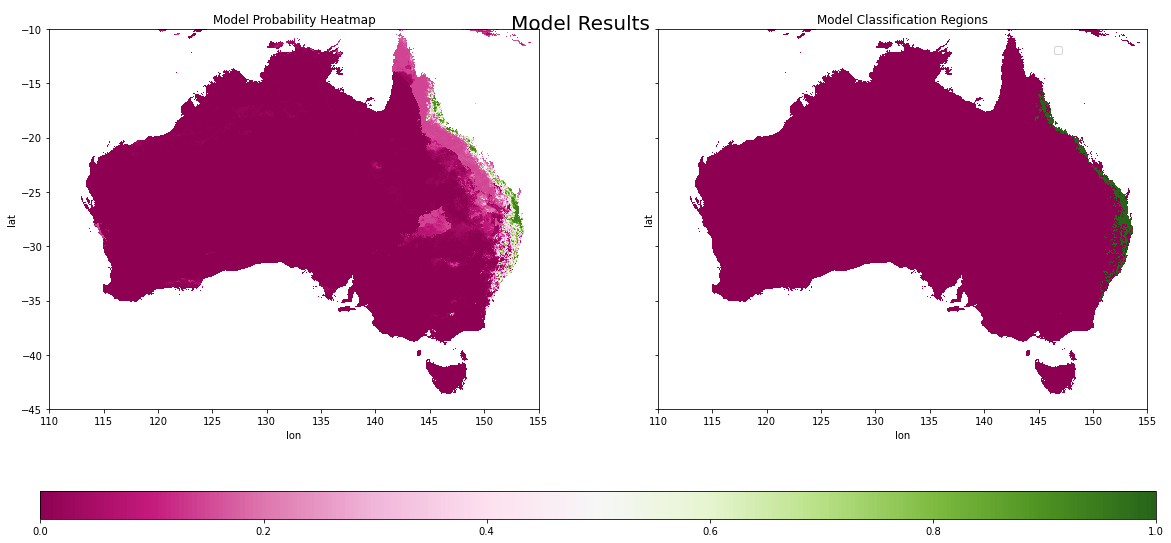

In [ ]:
plot_heatmap(resultant_image, frog_data_2019, "Model Results")

# SUMMISION

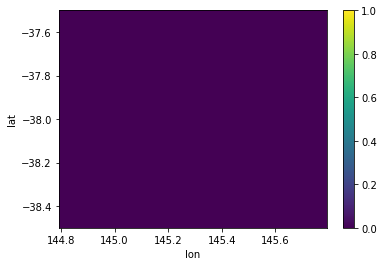

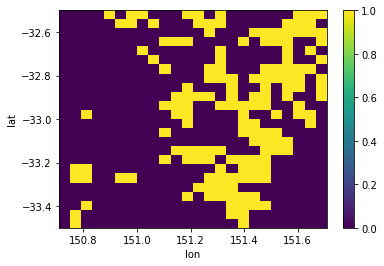

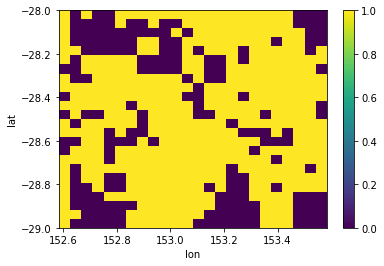

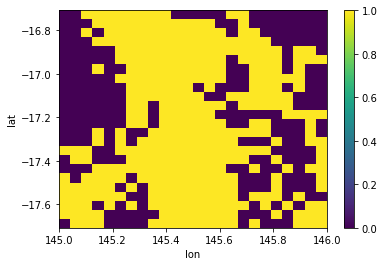

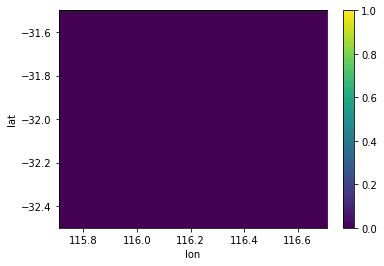

In [ ]:
submission = test_regions(model_2019, weather_data_2019, True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


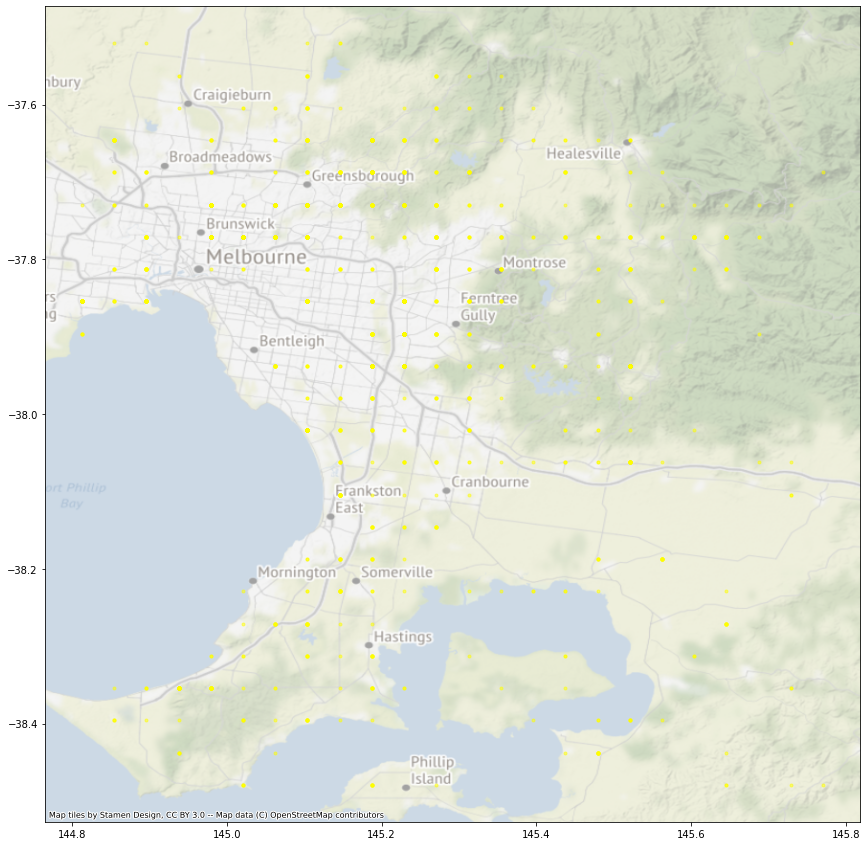

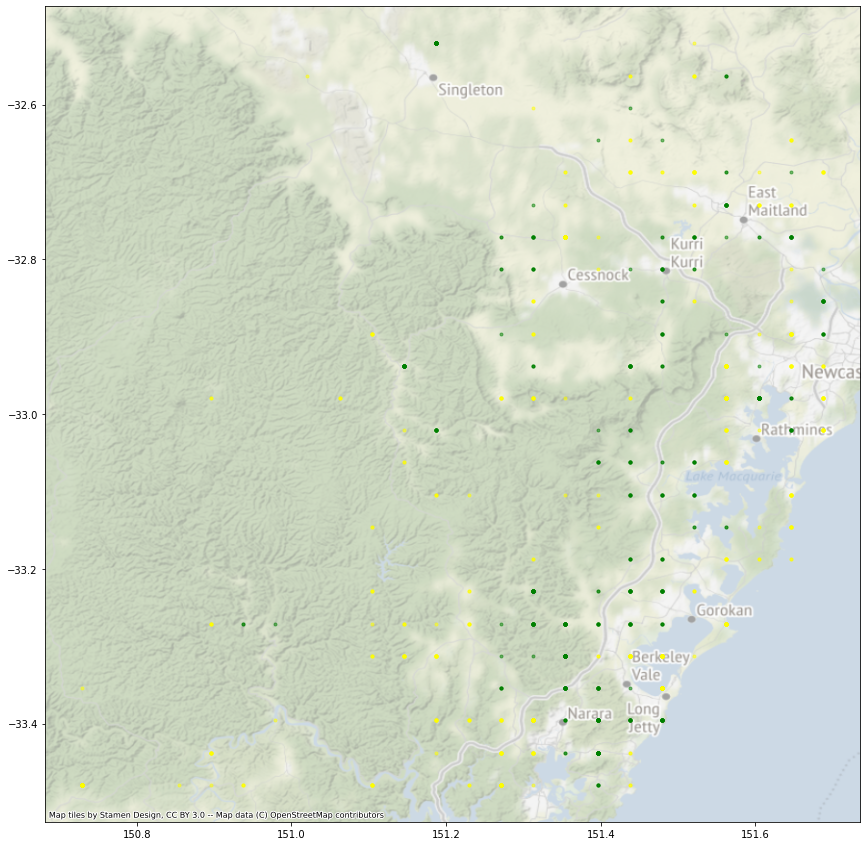

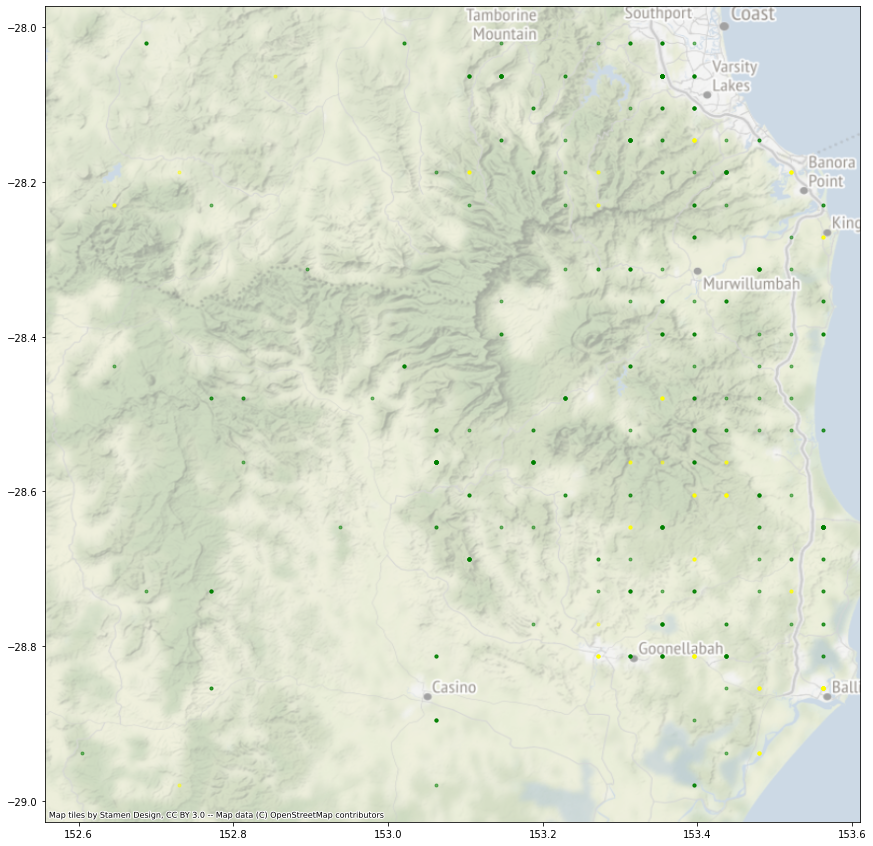

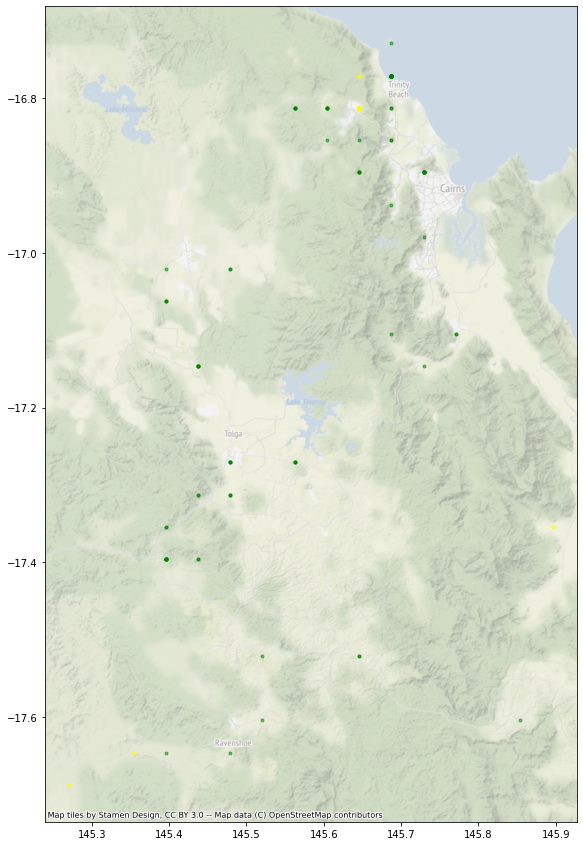

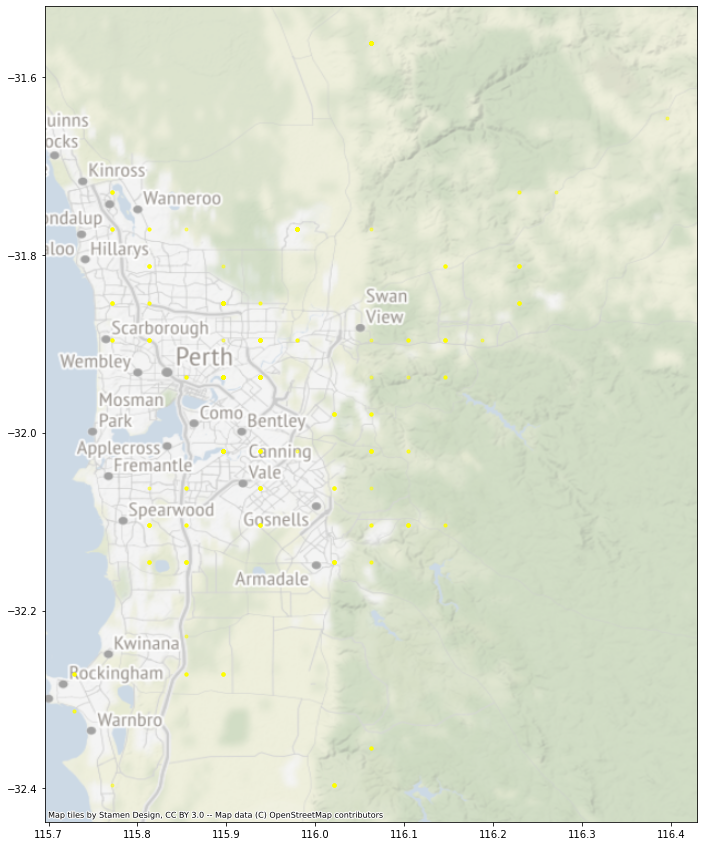

In [ ]:
# Read in test regions
test_1_regions = []
with open('/content/drive/MyDrive/EY/challenge_1_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))

regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]
for coordenates in regions:

  fig, ax = plt.subplots(figsize = (15, 15))
  filt = submission.occurrenceStatus == 1
  coord = submission[(submission.decimalLongitude >= coordenates["bbox"][0]) & (submission.decimalLongitude <= coordenates["bbox"][2]) &
                     (submission.decimalLatitude >= coordenates["bbox"][1]) & (submission.decimalLatitude <= coordenates["bbox"][3])]


  ax.scatter(coord[filt].decimalLongitude, coord[filt].decimalLatitude,
            color = 'green', marker='.', alpha=0.5)
  ax.scatter(coord[~filt].decimalLongitude, coord[~filt].decimalLatitude,
            color = 'yellow', marker='.', alpha=0.5)

  cx.add_basemap(ax, crs={'init':'epsg:4326'}, alpha=0.5)


In [ ]:
submission.to_csv('/content/drive/MyDrive/EY/final_submission.csv', index=None)